<a href="https://colab.research.google.com/github/renardelyon/Deep-Learning-with-Python-Exercise/blob/main/Temperature_Forecasting_Problem_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import requests


url = 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
r = requests.get(url, allow_redirects=True)

open('weather.zip', 'wb').write(r.content)

13565642

In [13]:
import zipfile
import os
import re

curr_dir_name = os.getcwd()
file_name = re.search(r' ([\w]*.zip)',' '.join(os.listdir())).group(1) 

with zipfile.ZipFile(os.path.join(curr_dir_name,file_name),'r') as zip:
  zip.extractall('/content')

In [14]:
import pandas as pd
import numpy as np

weather_df = pd.read_csv('jena_climate_2009_2016.csv')

In [15]:
weather_df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

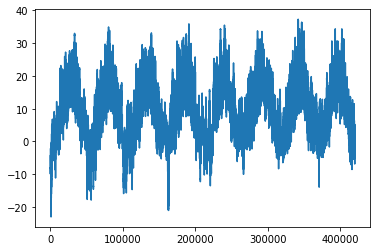

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(len(weather_df['T (degC)'])),weather_df['T (degC)'])
plt.show()

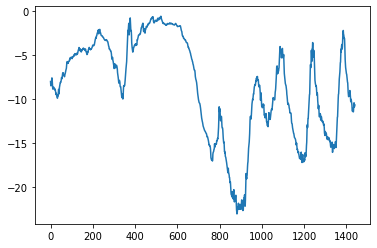

In [17]:
plt.plot(range(1441),weather_df.loc[:1440,'T (degC)'])
plt.show()

In [18]:
weather_df.drop(columns = 'Date Time',inplace=True)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
weather_df = scaler.fit_transform(weather_df)

In [20]:
def generator(data, lookback, delay, min_index, max_index,
                      shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while True:
    if shuffle:
      rows = np.random.randint(
              min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
          i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    samples = np.zeros((len(rows),
                      lookback // step,
                      data.shape[-1]))
    targets = np.zeros((len(rows),))
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [21]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(weather_df,
              lookback=lookback,
              delay=delay,
              min_index=0,
              max_index=200000,
              shuffle=True,
              step=step,
              batch_size=batch_size)
val_gen = generator(weather_df,
              lookback=lookback,
              delay=delay,
              min_index=200001,
              max_index=300000,
              step=step,
              batch_size=batch_size)
test_gen = generator(weather_df,
              lookback=lookback,
              delay=delay,
              min_index=300001,
              max_index=None,
              step=step,
              batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(weather_df) - 300001 - lookback)

In [26]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32,5,activation='relu',
                               input_shape=(None,weather_df.shape[-1])),
        tf.keras.layers.MaxPooling1D(3),
        tf.keras.layers.Conv1D(64,5,activation='relu'),
        tf.keras.layers.MaxPooling1D(3),
        tf.keras.layers.GRU(32,input_shape=(None,weather_df.shape[-1]),
                            dropout = 0.2,
                            recurrent_dropout=0.2),
        tf.keras.layers.Dense(1)
])

model.summary()

model.compile(optimizer=RMSprop(lr=0.01),
              loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=200)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          10304     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 22,017
Trainable params: 22,017
Non-trainable params: 0
__________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 56s 105ms/step - loss: 0.5195 - val_loss: 0.4008
Epoch 2/40
500/500 [==============================] - 49s 99ms/step - loss: 0.4177 - val_loss: 0.4258
Epoch 3/40
500/500 [==============================] - 50s 101ms/step - loss: 0.4168 - val_loss: 0.4207
Epoch 4/40
500/500 [==============================] - 50s 101ms/step - loss: 0.4272 - val_loss: 0.4432
Epoch 5/40
500/500 [==============================] - 49s 99ms/step - loss: 0.4370 - val_loss: 0.4750
Epoch 6/40
500/500 [==============================] - 49s 99ms/step - loss: 0.4330 - val_loss: 0.4229
Epoch 7/40
500/500 [==============================] - 50s 100ms/step - loss: 0.4417 - val_loss: 0.4884
Epoch 8/40
500/500 [==============================] - 50s 100ms/step - loss: 0.4269 - val_loss: 0.3923
Epoch 9/40
500/500 [==============================] - 50s 99ms/step - loss: 0.4306 - val_loss: 0.4518
Epoch 10/40
500/500 [==============================] - 50s 100ms/step - loss: 0.4407 - v

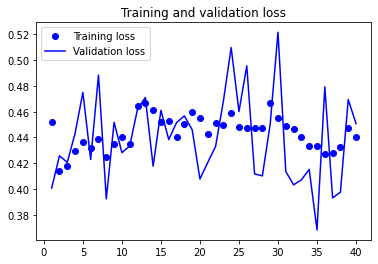

In [27]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()